# Distributional word representations

In [1]:
__author__ = "Christopher Potts"
__version__ = "CS224u, Stanford, Spring 2016 term"

## Contents

0. [Overview](#Overview)
0. [Set-up](#Set-up)
0. [Distributional matrices](#Distributional-matrices)
0. [Vector comparison](#Vector-comparison)
    0. [Euclidean distance](#Euclidean-distance)
    0. [Length normalization](#Length-normalization)
    0. [Cosine distance](#Cosine-distance)
    0. [Matching-based methods](#Matching-based-methods)
    0. [Summary](#Summary)
0. [Distributional neighbors](#Distributional-neighbors)    
0. [Matrix reweighting](#Matrix-reweighting)
    0. [Normalization](#Normalization)
    0. [Pointwise Mutual Information](#Pointwise-Mutual-Information)
    0. [TF-IDF](#TF-IDF)
0. [Dimensionality reduction](#Dimensionality-reduction)
0. [Visualization](#Visualization)
0. [GloVe word representations](#GloVe-word-representations)
0. [In-class exploration: The semantic orientation method](#In-class-exploration:-The-semantic-orientation-method)
0. [In-class bake-off: Word similarity](#In-class-bake-off:-Word-similarity)
0. [Word analogies evaluation](#Word-analogies-evaluation)
0. [Exploratory exercises](#Exploratory-exercises)
0. [Homework 1](#Homework-1)

## Overview

This codelab is about methods for creating effective vector representations of words from co-occurrence patterns in text. These are often called __distributional representations__, and the models are often called __vector space models__ (VSMs).

Terminological notes:

* Distributional representations are a specific kind of __distributed representation__. Later in the term, we'll look at models that use supervised learning to obtain vector-based word representations. These aren't purely distributional, in that they take advantage of more than just co-occcurence patterns among items in the vocabulary, but they share the idea that words can be modeled with vectors.

* If a neural network is used to train the representations, then they might be called __neural representations__.

* The term __word embedding__ is also used for distributed representations, including distributional ones. This term is a reminder that vector representations are meaningful only when embedded in and compared with others in a unified space (usually a matrix) of representations of the same type.

## Set-up

* Make sure your environment includes all the requirements for [the cs224u repository](https://github.com/cgpotts/cs224u).
* Download [the data distribution for this unit](https://web.stanford.edu/class/cs224u/data/vsmdata.zip), unpack it, and place it in the directory containing the course repository. (If you want to put it somewhere else, change `vsmdata_home` below.)
* Download [the Wikipedia 2014 + Gigaword 5 distribution](http://nlp.stanford.edu/data/glove.6B.zip) of the pretrained GloVe vectors, unzip it, and put the resulting folder in the the same directory as this notebook. (If you want to put it somewhere else, change `glove_home` below.)

In [2]:
vsmdata_home = "vsmdata"
glove_home = "glove.6B"

In [3]:
import os
import sys
import csv
import random
import itertools
from operator import itemgetter
from collections import defaultdict
import numpy as np
import scipy
import scipy.spatial.distance
from numpy.linalg import svd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import utils

In [4]:
%matplotlib inline

## Distributional matrices

Here's a basic recipe for building a word $\times$ word matrix:
    
0. Define a notion of co-occurrence context. This could be an entire document, a paragraph, a sentence, a clause, an NP — whatever domain seems likely to capture the associations you care about.
0. Scan through your corpus building a dictionary $d$ mapping word-pairs to counts. Every time a pair of words $w$ and $w'$ occurs in the same context (as you defined it in 1),  increment $d[(w, w')]$ by $1$.
0. Using the count dictionary $d$ that you collected in 2, establish your full vocabulary $V$, an ordered list of words types. For large collections of documents, $|V|$ will typically be huge. You will probably want to winnow the vocabulary at this point. You might do this by filtering to a specific subset, or just imposing a minimum count threshold. You might impose a minimum count threshold even if $|V|$ is small &mdash; for words with very low counts, you simply don't have enough evidence to say anything interesting.
0. Now build a matrix $M$ of dimension $|V| \times |V|$. Both the rows and the columns of $M$ represent words. Each cell $M[i, j]$ is filled with the count $d[(w_i, w_j)]$.

For different designs, the procedure differs slightly. For example, if you are building a word $\times$ document matrix, then the rows of $M$ represent words and the columns of $M$ represent documents. The scan in step 2 then just keeps track of (_word_, _document_) pairs &mdash; compiling the number of times that _word_ appears in _document_. Such matrices are often used in information retrieval, because the columns are multi-set representations of documents. They are much sparser than the the word $\times$ word matrices we will work with here. (In my experience, they yield lower-quality lexicons, but others have reported good results with them.)

The data distribution includes two pre-computed matrices of co-occurrence counts in IMDB movie reviews. The `build` function in the `utils` module for this repository  allows you to read them in:

Let's read these in now for use in later examples:

In [6]:
ww = utils.build(os.path.join(vsmdata_home, 'imdb-wordword.csv'))
wd = utils.build(os.path.join(vsmdata_home, 'imdb-worddoc.csv'))

There are some great pre-computed matrices available online too. These aren't matrices of counts, but rather more abstract values computed using methods like those under discussion here. Just for kicks, let's load in some [GloVe vectors](#GloVe-word-representations):

In [8]:
glv = utils.build_glove(os.path.join(glove_home, 'glove.6B.50d.txt'))

## Vector comparison

Vector comparisons form the heart of our analyses in this context. For the most part, we are interested in measuring the _distance_ between vectors. The guiding idea is that semantically related words should be close together in the vector spaces we build, and semantically unrelated words should be far apart.

The [scipy.spatial.distance](http://docs.scipy.org/doc/scipy-0.14.0/reference/spatial.distance.html) module has a lot of vector comparison methods, so you might check them out if you want to go beyond the functions defined and explored here. Read the documentation closely, though: many of those methods are defined only for binary vectors, whereas the VSMs we'll use allow all float values in principle.

### Euclidean distance

The most basic and intuitive distance measure between vectors is __euclidean distance__. The euclidean distance between two vectors $u$ and $v$ of dimension $n$ is 

$$\sqrt{\sum_{i=1}^{n} |u_{i}-v_{i}|^2}$$ 

In two-dimensions, this corresponds to the length of the most direct line between the two points.

Here, we just rely on `scipy` to define it:

In [9]:
def euclidean(u, v):    
    """Eculidean distance between 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    # Use scipy's method:
    return scipy.spatial.distance.euclidean(u, v)
    # Or define it yourself:
    # return vector_length(u - v)    

The comment above shows how to define this measure yourself. The function used there is the __length__ of a vector $u$ of dimension $n$, which is defined as 

$$\|u\| = \sqrt{\sum_{i=1}^{n} u_{i}^{2}}$$ 

Here's the code:

In [10]:
def vector_length(u):
    """Length (L2) of the 1d np.array `u`. Returns a new np.array with the 
    same dimensions as `u`."""
    return np.sqrt(np.dot(u, u))

Here's the tiny vector space from the screencast on vector comparisons associated with this notebook:

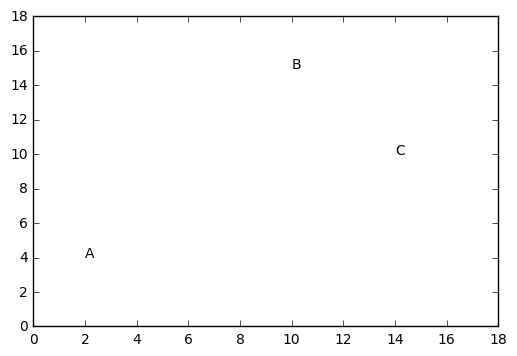

In [11]:
ABC = np.array([
    [ 2.0,  4.0],  # A
    [10.0, 15.0],  # B
    [14.0, 10.0]]) # C

def plot_ABC(m):
    plt.plot(m[:,0], m[:,1], marker='', linestyle='')
    plt.xlim([0,np.max(m)*1.2])
    plt.ylim([0,np.max(m)*1.2])
    for i, x in enumerate(['A','B','C']):
        plt.annotate(x, m[i,:])

plot_ABC(ABC)

The euclidean distances align well with the raw visual distance in the plot:

In [12]:
euclidean(ABC[0], ABC[1])

13.601470508735444

In [13]:
euclidean(ABC[1], ABC[2])

6.4031242374328485

However, suppose we think of the vectors as word meanings in the vector-space sense. In that case, the values don't look good: the distributions of B and C are more or less directly opposed, suggesting very different meanings, whereas A and B are rather closely aligned, abstracting away from the fact that the first is far  less frequent than the second. In terms of the large  models we will soon explore, A and B resemble a pair like __superb__ and __good__, which have similar meanings but very different frequencies. In contrast, B and C are like __good__ and __disappointing__ &mdash; similar overall frequencies but different distributions with respect to the overall vocabulary.

### Length normalization

These affinities are immediately apparent if we normalize the vectors by their length. To do this, we use `vector_length` to define `length_norm`:

In [14]:
def length_norm(u):
    """L2 norm of the 1d np.array `u`. Returns a float."""
    return u / vector_length(u)

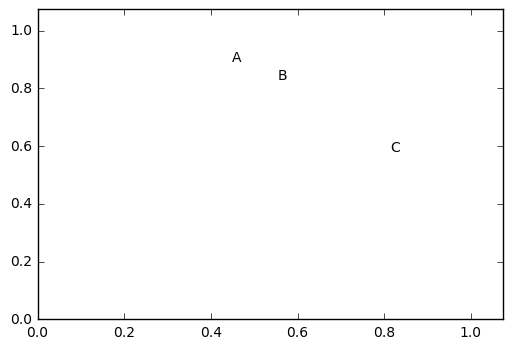

In [15]:
plot_ABC(np.array([length_norm(row) for row in ABC]))

Here, the connection between A and B is more apparent, as is the opposition between B and C.

### Cosine distance

__Cosine distance__ takes overall length into account. The cosine distance between two vectors $u$ and $v$ of dimension $n$ is 

$$1 - \left(\frac{\sum_{i=1}^{n} u_{i} \cdot v_{i}}{\|u\|\cdot \|v\|}\right)$$

The similarity part of this (the righthand term of the subtraction) is actually measuring the _angles_ between the two vectors. The result is the same (in terms of rank order) as one gets from first normalizing both vectors using `vector_length` and then calculating their Euclidean distance.

In [16]:
def cosine(u, v):        
    """Cosine distance between 1d np.arrays `u` and `v`, which must have 
    the same dimensionality. Returns a float."""
    # Use scipy's method:
    return scipy.spatial.distance.cosine(u, v)
    # Or define it yourself:
    # return 1.0 - (np.dot(u, v) / (vector_length(u) * vector_length(v)))

### Matching-based methods

Matching-based methods are also common in the literature. The basic `matching` measure  effectively creates a vector consisting of all of the smaller of the two values at each coordinate, and then sums them:

In [17]:
def matching(u, v):    
    """Matching coefficient between the 1d np.array vectors `u` and `v`, 
    which must have the same dimensionality. Returns a float."""
    # The scipy implementation is for binary vectors only. 
    # This version is more general.
    return np.sum(np.minimum(u, v))

One approach to normalizing the `matching` values is the __Jaccard coefficient__. The numerator is the matching coefficient. The denominator &mdash; the normalizer &mdash; is intuitively like the set union: for binary vectors it gives the cardinality of the union of the two being compared:

In [18]:
def jaccard(u, v):    
    """Jaccard distance between the 1d np.arrays `u` and `v`, which must 
    have the same dimensionality. Returns a float."""
    # The scipy implementation is for binary vectors only. 
    # This version is more general.
    return 1.0 - (matching(u, v) / np.sum(np.maximum(u, v)))

### Summary

Suppose we set for ourselves the goal of associating A with B and disassociating B from C, in keeping with the semantic intuition expressed above. Then we can assess distance measures by whether they achieve this goal:

In [19]:
for m in (euclidean, cosine, jaccard):
    fmt = {'n': m.__name__,  
           'AB': m(ABC[0], ABC[1]), 
           'BC': m(ABC[1], ABC[2])}
    print('%(n)15s(A, B) = %(AB)5.2f %(n)15s(B, C) = %(BC)5.2f' % fmt)

      euclidean(A, B) = 13.60       euclidean(B, C) =  6.40
         cosine(A, B) =  0.01          cosine(B, C) =  0.07
        jaccard(A, B) =  0.76         jaccard(B, C) =  0.31


## Distributional neighbors

The `neighbors` function is an investigative aide. For a given `word`, it ranks all the words in the vocabulary `rownames` according to their distance from `word`, as measured by `distfunc` in matrix `mat`:

In [20]:
def neighbors(word, mat, rownames, distfunc=cosine):    
    """Tool for finding the nearest neighbors of `word` in `mat` according 
    to `distfunc`. The comparisons are between row vectors.
    
    Parameters
    ----------
    word : str
        The anchor word. Assumed to be in `rownames`.
        
    mat : np.array
        The vector-space model.
        
    rownames : list of str
        The rownames of mat.
            
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure  
        between 1d vectors.
        
    Raises
    ------
    ValueError
        If word is not in rownames.
    
    Returns
    -------    
    list of tuples
        The list is ordered by closeness to `word`. Each member is a pair 
        (word, distance) where word is a str and distance is a float.
    
    """
    if word not in rownames:
        raise ValueError('%s is not in this VSM' % word)
    w = mat[rownames.index(word)]
    dists = [(rownames[i], distfunc(w, mat[i])) for i in range(len(mat))]
    return sorted(dists, key=itemgetter(1), reverse=False)

By playing around with this function, you can start to get a sense for how the distance functions differ. Here are some example calls; you might try some new words to get a feel for what these matrices are like and how different words look.

In [21]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('excellent', 0.0026965023912962627),
 ('outstanding', 0.0027344413235226295),
 ('beautifully', 0.0027345163104325332),
 ('brilliant', 0.0027888643627086429)]

In [22]:
neighbors(word='superb', mat=ww[0], rownames=ww[1], distfunc=euclidean)[: 5]

[('superb', 0.0),
 ('familiar', 1448.8919904533948),
 ('violent', 1630.3723501090174),
 ('follows', 1647.0276257549538),
 ('convincing', 1701.2260284865147)]

The above rankings actually tend to look pretty good, with `cosine` less likely to associate words that happen to have similar frequency. 

The GloVe vectors look even better &mdash; but they are based on much more than just raw counts, as we'll see soon:

In [23]:
neighbors(word='superb', mat=glv[0], rownames=glv[1], distfunc=cosine)[: 5]

[('superb', 2.2204460492503131e-16),
 ('brilliant', 0.15809110259014769),
 ('impressive', 0.19352861376442676),
 ('masterful', 0.22871323564771928),
 ('excellent', 0.22928471014596696)]

## Matrix reweighting

The goal of reweighting is to amplify the important, trustworthy, and unusual, while deemphasizing the mundane and the quirky. Absent a defined objective function, this will remain fuzzy, but the intuition behind moving away from raw counts is that frequency is a poor proxy for our target semantic ideas.

### Normalization

Normalization (row-wise or column-wise) is perhaps the simplest form of reweighting. With [length_norm](#Length-normalization), we normalize using `vector_length`. We can also normalize each row by the sum of its values, which turns each row into a probability distribution over the columns:

In [24]:
def prob_norm(u):
    """Normalize 1d np.array `u` into a probability distribution. Assumes 
    that all the members of `u` are positive. Returns a 1d np.array of 
    the same dimensionality as `u`."""
    return u / np.sum(u)

These normalization measures are insensitive to the _magnitude_ of the underlying counts. This is often a mistake in the messy world of large data sets; $[1,10]$ and $[1000,10000]$ are very different in ways that will be partly or totally obscured by normalization.

### Pointwise Mutual Information

__Pointwise Mutual Information__ (PMI) addresses this issue, at least in part. The PMI for word $\times$ context pair $(w,c)$ is 

$$\log\left(\frac{P(w,c)}{P(w) \cdot P(c)}\right)$$

with $\log(0) = 0$. This is a measure of how far that cell's value deviates from what we would expect given the row and column sums for that cell. 

__Positive PMI__ (PPMI) maps all negative PMI values to 0.0. Our function `pmi` has `positive=True` as a default, in light of the arguments in [Levy and Goldberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization), section 3.3.

In [25]:
def pmi(mat, rownames=None, positive=True):
    """Pointwise Mutual Information with Positive on by default.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
           
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    positive : bool (default: True)
        Implements Positive PMI.
        
    Returns
    -------    
    (np.array, list of str)
       The first member is the PMI-transformed version of `mat`, and the 
       second member is `rownames` (unchanged).
    
    """    
    # Joint probability table:
    p = mat / np.sum(mat, axis=None)
    # Pre-compute column sums:
    colprobs = np.sum(p, axis=0)
    # Vectorize this function so that it can be applied rowwise:
    np_pmi_log = np.vectorize((lambda x : _pmi_log(x, positive=positive)))
    p = np.array([np_pmi_log(row / (np.sum(row)*colprobs)) for row in p])   
    return (p, rownames)

def _pmi_log(x, positive=True):
    """With `positive=False`, return log(x) if possible, else 0.
    With `positive=True`, log(x) is mapped to 0 where negative."""
    val = 0.0
    if x > 0.0:
        val = np.log(x)
    if positive:
        val = max([val,0.0])
    return val

Here, we reweight the word $\times$ word IMDB matrix from above using PPMI:

In [100]:
#Positive PMI
ww_ppmi = pmi(mat=ww[0], rownames=ww[1], positive=True)
wd_ppmi = pmi(mat=wd[0], rownames=wd[1], positive=True)

In [101]:
#PMI
ww_pmi = pmi(mat=ww[0], rownames=ww[1], positive=False)
wd_pmi = pmi(mat=wd[0], rownames=wd[1], positive=False)

In [27]:
neighbors(word='superb', mat=ww_ppmi[0], rownames=ww_ppmi[1], distfunc=cosine)[: 5]

[('superb', 0.0),
 ('excellent', 0.41348274842943578),
 ('performances', 0.44391628568702513),
 ('brilliant', 0.45785117509986173),
 ('performance', 0.46856555779383202)]

### TF-IDF

Perhaps the best known reweighting schemes is __Term Frequency&ndash;Inverse Document Frequency__ (TF-IDF), which is, I believe, still the backbone of today's Web search technologies. As the name suggests, it is built from TF and IDF measures:

For a word $w$ and collection of documents $D$ containing document $d$:

* TF$(w,d)$: $P(w \mid c)$. (In our VSMs, this is column-normalization using `prob_norm`.)
* IDF$(w,D)$: $\log\left(\frac{|D|}{|\{d \in D : w \in d\}|}\right)$, where $\log(0)=0$.
* TFIDF$(w,d,D)$: TF$(w,d)$ * IDF$(w,D)$

In [28]:
def tfidf(mat, rownames=None):
    """TF-IDF 
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
       
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    Returns
    -------
    (np.array, list of str)    
       The first member is the TF-IDF-transformed version of `mat`, and 
       the second member is `rownames` (unchanged).
    
    """
    colsums = np.sum(mat, axis=0)
    doccount = mat.shape[1]
    w = np.array([_tfidf_row_func(row, colsums, doccount) for row in mat])
    return (w, rownames)

def _tfidf_row_func(row, colsums, doccount):
    df = float(len([x for x in row if x > 0]))
    idf = 0.0
    # This ensures a defined IDF value >= 0.0:
    if df > 0.0 and df != doccount:
        idf = np.log(doccount / df)
    tfs = row/colsums
    return tfs * idf

TF-IDF generally performs best with sparse matrices. It severely punishes words that appear in many documents; if a word appears in every document, then its IDF value is 0. As a result, it can even be problematic with verb dense word $\times$ word matrices like `ww`, where most words appear with most other words due to the permissive notion of co-occurrence used to create it.

Here's an example using our word&nbsp;x&nbsp;document matrix `wd`:

In [29]:
wd_tfidf = tfidf(mat=wd[0], rownames=wd[1])

In [70]:
ww_tfidf = tfidf(mat=ww[0], rownames=ww[1])

In [30]:
neighbors(word='superb', mat=wd_tfidf[0], rownames=wd_tfidf[1], distfunc=cosine)[: 5]

[('superb', 1.1102230246251565e-16),
 ('outstanding', 0.72256301656130351),
 ('remain', 0.73606093603489875),
 ('viewed', 0.74639986506462108),
 ('and', 0.74880553661599958)]

For a more full-featured version of TF-IDF, see [sklearn.feature_extraction.text.TfidfTransformer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer). 

__Important__: `sklearn`'s version assumes that term frequency (TF) is defined row-wise and document frequency is defined column-wise. That is, it assumes `sklearn`'s document $\times$ word basic design, which makes sense for classification tasks, where the design is example $\times$ features. This is the reverse of the above.

## Dimensionality reduction

The above methods deliver solid results. However, they are not capable of capturing higher-order associations in the data. For example, both _gnarly_ and _wicked_ are used as slangily positive adjectives. We thus expect them to have many of the same neighbors. However, at least stereotypically, _gnarly_ is Californian and _wicked_ is Bostonian. Thus, they are unlikely 
to occur often in the same texts. Dimensionality reduction techniques are often capable of capturing their semantic similarity (and have the added advantage of shrinking the size of our data structures).

The general goal of dimensionality reduction is to eliminate rows/columns that are highly correlated while bringing similar things together and pushing dissimilar things apart. __Latent Semantic Analysis__ (LSA) is a prominent method. It is an application of truncated __singular value decomposition__ (SVD). SVD is a central matrix operation; 'truncation' here means looking only at submatrices of the full decomposition. LSA seeks not only to find a reduced-sized matrix but also to capture similarities that come not just from direct co-occurrence, but also from second-order co-occurrence.

In [31]:
def lsa(mat=None, rownames=None, k=100):
    """Latent Semantic Analysis using pure scipy.
    
    Parameters
    ----------
    mat : 2d np.array
       The matrix to operate on.
           
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    k : int (default: 100)
        Number of dimensions to truncate to.
        
    Returns
    -------    
    (np.array, list of str)
        The first member is the SVD-reduced version of `mat` with 
        dimension (m x k), where m is the rowcount of mat and `k` is 
        either the user-supplied k or the column count of `mat`, whichever 
        is smaller. The second member is `rownames` (unchanged).

    """    
    rowmat, singvals, colmat = svd(mat, full_matrices=False)
    singvals = np.diag(singvals)
    trunc = np.dot(rowmat[:, 0:k], singvals[0:k, 0:k])
    return (trunc, rownames)

Here's a look at the example from the slides:

In [32]:
gnmat = np.array([
    [1,0,1,0,0,0],
    [0,1,0,1,0,0],
    [1,1,1,1,0,0],
    [0,0,0,0,1,1],
    [0,0,0,0,0,1]], dtype='float64')
gn_rownames = ['gnarly', 'wicked', 'awesome', 'lame', 'terrible']

In [33]:
neighbors(word='gnarly', mat=gnmat, rownames=gn_rownames)

[('gnarly', 2.2204460492503131e-16),
 ('awesome', 0.29289321881345254),
 ('wicked', 1.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

We see that _gnarly_ and _wicked_ are not close to each other. (Well, it's a small space, but they are as close as _gnarly_ and _lame_.) Reweighting by PMI, PPMI, or TF-IDF is no help. LSA to the rescue:

In [34]:
gnmat_lsa = lsa(mat=gnmat, rownames=gn_rownames, k=2)

In [35]:
neighbors(word='gnarly', mat=gnmat_lsa[0], rownames=gnmat_lsa[1])

[('gnarly', 0.0),
 ('wicked', 0.0),
 ('awesome', 0.0),
 ('lame', 1.0),
 ('terrible', 1.0)]

The [sklearn.decomposition](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) module contains an implementation of LSA ([TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD)) that you might want to switch to for real experiments: 

* The `sklearn` version is more flexible than the above in that it can operate on both dense matrices (Numpy arrays) and sparse matrices (from Scipy).
* The `sklearn` version will make it easy to try out other dimensionality reduction methods in your own code; Principal Component Analysis ([PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)) and Non-Negative Matrix Factorization ([NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html#sklearn.decomposition.NMF)) are definitely worth a look.

## Visualization

You can begin to get a feel for what your matrix is like by poking around with the `neighbors` function to see who is close to or far from whom. But this kind of sampling is unlikely to lead to robust new insights, unless you luck out and start to see an interesting cluster of associations developing.

[t-Distributed Stochastic Neighbor Embedding](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) (t-SNE) is a powerful method for visualizing high-dimensional vector spaces in 2d. It allows you to find associations in an intuitive way, to guide later and more precise investigations. `sklearn` now contains a high-performance implementation: [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE).

In [36]:
def tsne_viz(
        mat,
        rownames,
        colors=None,
        output_filename=None,
        figheight=40,
        figwidth=50):     
    """2d plot of `mat` using t-SNE, with the points labeled by `rownames`, 
    aligned with `colors` (defaults to all black).
    
    Parameters
    ----------    
    mat : 2d np.array
        The matrix to visualize.
        
    rownames : list of str
        Names of the points to visualize.
                
    colors : list of colornames or None (default: None)
        Optional list of colors for rownames. The color names just need to 
        be interpretable by matplotlib. If they are supplied, they need to 
        have the same length as rownames, or indices if that is not None. 
        If `colors=None`, then all the words are displayed in black.
      
    output_filename : str (default: None)
        If not None, then the output image is written to this location. The 
        filename suffix determines the image type. If None, then 
        `plt.plot()` is called, with the behavior determined by the 
        environment.
        
    figheight : int (default: 40)
        Height in display units of the output.
            
    figwidth : int (default: 50)
        Width in display units of the output.
        
    """
    indices = list(range(len(rownames)))
    # Colors:
    if not colors:
        colors = ['black' for i in indices]    
    # Recommended reduction via PCA or similar:
    n_components = 50 if mat.shape[1] >= 50 else mat.shape[1]
    dimreduce = PCA(n_components=n_components)
    mat = dimreduce.fit_transform(mat)
    # t-SNE:
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)    
    tsnemat = tsne.fit_transform(mat) 
    # Plot values:
    vocab = np.array(rownames)[indices]
    xvals = tsnemat[indices, 0] 
    yvals = tsnemat[indices, 1]
    # Plotting:
    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_figheight(40)
    fig.set_figwidth(50)
    ax.plot(xvals, yvals, marker='', linestyle='')
    # Text labels:
    for word, x, y, color in zip(vocab, xvals, yvals, colors):
        ax.annotate(word, (x, y), fontsize=8, color=color)
    # Output:
    if output_filename:
        plt.savefig(output_filename, bbox_inches='tight')
    else:
        plt.show()

Here's the code for running this on `ww_ppmi` using the default settings:

In [ ]:
tsne_viz(mat=ww_ppmi[0], rownames=ww_ppmi[1])

For more on the techniques, we highly recommend van der Maaten's compelling talk [Visualizing Data Using t-SNE](https://www.youtube.com/watch?v=RJVL80Gg3lA).

## GloVe word representations

We've so far performed our matrix manipulations without an explicit objective function. Rather, we've just had in mind informal ideas about capturing semantic relatedness. The  advantage of an explicit objective function is that we can apply standard optimization techniques.

[Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf) introduce an objective function for semantic word representations. Roughly speaking, the objective is to learn vectors for words $w_{i}$ and $w_{j}$ such that their dot product is proportional to their co-occurrence count. I won't venture a full technical summary of the GloVe method here. Check out [the GloVe project homepage](http://nlp.stanford.edu/projects/glove/), which links to C code, word vectors, and other resources. I also highly recommend
[Jeffrey Pennington's EMNLP talk 'Global vectors for word representation'](https://www.youtube.com/watch?v=RyTpzZQrHCs).

The following implementation is an attempt to give the most stripped-down, bare-bones version of the GloVe method possible. In the papers and associated implementation, the authors use the [Adaptive Gradient (AdaGrad) learning method](http://jmlr.org/papers/v12/duchi11a.html). [Jon Gauthier released a Python version that uses that method as well](http://www.foldl.me/2014/glove-python/). Both of these implementations also do considerably more sophisticated things when it comes to compiling the basic co-occurrence counts. The code here is really just meant for instructional purposes. That said, it's a testament to the power of the method that it delivers high quality word vectors even in this basic form!

In [40]:
def glove(mat, rownames, n=100, xmax=100, alpha=0.75, 
          iterations=100, learning_rate=0.05, 
          display_progress=True):
    """Basic GloVe. 
    
    Parameters
    ----------
    mat : 2d np.array
        This must be a square count matrix.
        
    rownames : list of str or None
        Not used; it's an argument only for consistency with other methods 
        defined here.
        
    n : int (default: 100)
        The dimensionality of the output vectors.
    
    xmax : int (default: 100)
        Words with frequency greater than this are given weight 1.0.
        Words with frequency under this are given weight (c/xmax)**alpha
        where c is their count in mat (see the paper, eq. (9)).
        
    alpha : float (default: 0.75)
        Exponent in the weighting function (see the paper, eq. (9)).
    
    iterations : int (default: 100)
        Number of training epochs.
        
    learning_rate : float (default: 0.05)
        Controls the rate of SGD weight updates.
        
    display_progress : bool (default: True) 
        Whether to print iteration number and current error to stdout.
        
    Returns
    -------
    (np.array, list of str)
       The first member is the learned GloVe matrix and the second is
       `rownames` (unchanged).

    """        
    m = mat.shape[0]
    W = utils.randmatrix(m, n) # Word weights.
    C = utils.randmatrix(m, n) # Context weights.
    B = utils.randmatrix(2, m) # Word and context biases.
    indices = list(range(m))
    for iteration in range(iterations):
        error = 0.0        
        random.shuffle(indices)
        for i, j in itertools.product(indices, indices):
            if mat[i,j] > 0.0:     
                # Weighting function from eq. (9)
                weight = (mat[i,j] / xmax)**alpha if mat[i,j] < xmax else 1.0
                # Cost is J' based on eq. (8) in the paper:
                diff = np.dot(W[i], C[j]) + B[0,i] + B[1,j] - np.log(mat[i,j])                
                fdiff = diff * weight                
                # Gradients:
                wgrad = fdiff * C[j]
                cgrad = fdiff * W[i]
                wbgrad = fdiff
                wcgrad = fdiff
                # Updates:
                W[i] -= (learning_rate * wgrad) 
                C[j] -= (learning_rate * cgrad) 
                B[0,i] -= (learning_rate * wbgrad) 
                B[1,j] -= (learning_rate * wcgrad)                 
                # One-half squared error term:                              
                error += 0.5 * weight * (diff**2)
        if display_progress:
            utils.progress_bar("iteration %s: error %s" % (iteration, error))
    if display_progress:
        sys.stderr.write('\n')
    # Return the sum of the word and context matrices, per the advice 
    # in section 4.2:
    return (W + C, rownames)

It is not easy analyze GloVe values derived from real data, but the following little simulation suggests that `glove` is working as advertised: it does seem to reliably deliver vectors whose dot products are proportional to their co-occurrence counts:

iteration 2999: error 0.0318979844014


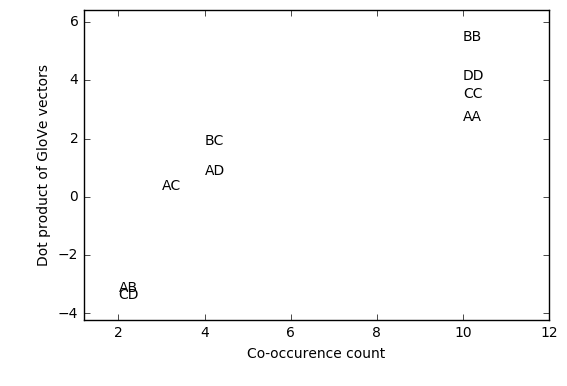

In [41]:
def glove_analysis(n=2, iterations=3000):
    """Run GloVe and plot the dot products of the resulting vectors relative
    to the input co-occurrence counts. `n` and `iterations` are parameters to
    `glove`. Higher `iterations` and`n` come closer to the ideal."""
    vocab = ['A', 'B', 'C', 'D']
    mat = np.array([
        [10.0,  2.0,  3.0,  4.0],
        [ 2.0, 10.0,  4.0,  1.0],
        [ 3.0,  4.0, 10.0,  2.0],
        [ 4.0,  1.0,  2.0, 10.0]])
    glv, _ = glove(mat, vocab, n=n, iterations=iterations)
    labels = []
    cooccurs = []
    vals = []
    m = len(vocab)
    for i in range(m):        
        for j in range(i, m):
            labels.append(vocab[i]+vocab[j])
            cooccurs.append(mat[i,j])
            vals.append(glv[i].dot(glv[j]))            
    plt.plot(cooccurs, vals, marker='', linestyle='')
    for c, v, lab in zip(cooccurs, vals, labels):
        plt.annotate(lab, (c, v))    
    plt.xlabel("Co-occurence count")
    plt.ylabel("Dot product of GloVe vectors")
    plt.xlim([np.min(cooccurs)*1.2,np.max(cooccurs)*1.2])
    plt.ylim([np.min(vals)*1.2,np.max(vals)*1.2])
    
glove_analysis()    

The following takes a while to run, but the results look good, and they can be  improved by adding more vocabulary items, allowing more iterations, and increasing the dimension size. For the output with 100 dimensions and 100 iterations, check out this image: [fig/imdb-wordword-glove100.pdf](fig/imdb-wordword-glove100.pdf).

In [42]:
def glove_viz(mat, rownames, word_count=1000, 
        iterations=10, n=50, display_progress=True):    
    """Visualize a random sample of `word_count` words in `mat` 
    after GloVe training."""   
    glove_indices = np.random.choice(range(len(rownames)), size=word_count)
    samp = np.array(rownames)[glove_indices]
    glovemat, _ = glove(mat[glove_indices, :], samp, iterations=iterations, n=n)
    tsne_viz(mat=glovemat, rownames=samp)

In [43]:
# glove_viz(mat=ww[0], rownames=ww[1])

## In-class exploration: The semantic orientation method

The [t-SNE visualization of our running example](#Visualization) suggests some lexical clusters that in turn suggest the beginnings of a lexicon. The __semantic orientation__ method of [Turney and Littman 2003](http://doi.acm.org/10.1145/944012.944013) is a general method for building such lexicons for any desired semantic dimension.

__Your task__: Pick a new semantic opposition and see how well `semantic_orientation` captures it using a VSM built from `wordword` or `worddoc`. 

The broader goal is to give you a chance to explore the code and concepts above with an eye towards building a semantic lexicon. Using [`neighbors`](#Distributional-neighbors) will give you a feel for what works and what doesn't. 

__Submit__: At the end of class, bring a summary of your opposition (e.g., "Love/Hate &ndash; worked okay") to one of the teaching team. We'll summarize the overall findings in the class discussion forum later.

The semantic orientation method simply exploits our above insights about vector similarity. Here are the steps:

0. Define two seed-sets $S_1$ and $S_2$ of words (they should be opposing in some way that is appropriate for your matrix).
0. Pick a vector distance measure $f$.
0. For the word $w$ of interest, use $f$ to get the sum of all distances between $w$ and the words in $S_1$. Do the same for $S_2$.
0. The score is the sum for $S_1$ minus the sum for $S_2$.

Here's an implementation; the default seed values correspond to Turney and Littman's basic sentiment experiment.

In [44]:
def semantic_orientation(
        mat, 
        rownames,
        seeds1=('bad', 'nasty', 'poor', 'negative', 'unfortunate', 'wrong', 'inferior'),
        seeds2=('good', 'nice', 'excellent', 'positive', 'fortunate', 'correct', 'superior'),
        distfunc=cosine):    
    """No frills implementation of the semantic Orientation (SO) method of 
    Turney and Littman. seeds1 and seeds2 should be representative members 
    of two intutively opposing semantic classes. The method will then try 
    to rank the vocabulary by its relative association with each seed set.
        
    Parameters
    ----------
    mat : 2d np.array
        The matrix used to derive the SO ranking.
        
    rownames : list of str
        The names of the rows of `mat` (the vocabulary).
        
    seeds1 : tuple of str
        The default is the negative seed set of Turney and Littman.
        
    seeds2 : tuple of str
        The default is the positive seed set of Turney and Littman.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors. 
    
    Returns
    -------    
    list of tuples
        The vocabulary ranked according to the SO method, with words 
        closest to `seeds1` at the top and words closest to `seeds2` at the 
        bottom. Each member of the list is a (word, score) pair.
    
    """    
    sm1 = _so_seed_matrix(seeds1, mat, rownames)
    sm2 = _so_seed_matrix(seeds2, mat, rownames)
    scores = [(rownames[i], _so_row_func(mat[i], sm1, sm2, distfunc)) for i in range(len(mat))]
    return sorted(scores, key=itemgetter(1), reverse=False)

def _so_seed_matrix(seeds, mat, rownames):
    indices = [rownames.index(word) for word in seeds if word in rownames]
    if not indices:
        raise ValueError('The matrix contains no members of the seed set: %s' % ",".join(seeds))
    return mat[np.array(indices)]
    
def _so_row_func(row, sm1, sm2, distfunc):
    val1 = np.sum([distfunc(row, srow) for srow in sm1])
    val2 = np.sum([distfunc(row, srow) for srow in sm2])
    return val1 - val2    

An example function call using `ww_ppmi`:

In [45]:
so = semantic_orientation(mat=ww_ppmi[0], rownames=ww_ppmi[1])
so[:5]

[('poor', -1.2397213851709856),
 ('bad', -1.2213826663029765),
 ('worst', -1.1351666124996971),
 ('awful', -1.1048739686983322),
 ('waste', -1.0236360853957418)]

In [46]:
so[-5:]

[('well', 0.75360884916526505),
 ('superior', 0.81493927722684845),
 ('great', 0.89100807935189197),
 ('nice', 0.93295714329167545),
 ('excellent', 1.1687082653604852)]

## In-class bake-off: Word similarity

Word similarity datasets have long been used to evaluate distributional (more generally, distributed) representations. This section provides basic code for conducting such analyses with four datasets: 

* [WordSim-353](http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/) 
* [MTurk-287](http://tx.technion.ac.il/~kirar/Datasets.html)
* [Mturk-771](http://www2.mta.ac.il/~gideon/mturk771.html)
* [The MEN Test Collection](http://clic.cimec.unitn.it/~elia.bruni/MEN) (3,000 pairs)

For the first three, the numeral in its name is the number of pairs it contains.

If you want to push this task further, consider using additional datasets from [http://wordvectors.org/](http://wordvectors.org/) and perhaps even taking advantage of the evaluation infrastructure it provides. (For additional details, see [the associated paper](http://www.aclweb.org/anthology/P/P14/P14-5004.pdf).)

First, a bit of reader infrastructure for the datasets included in `vsmdata/wordsim`:

In [47]:
def wordsim_dataset_reader(src_filename, header=False, delimiter=','):    
    """Basic reader that works for all four files, since they all have the 
    format word1,word2,score, differing only in whether or not they include 
    a header line and what delimiter they use.
    
    Parameters
    ----------
    src_filename : str
        Full path to the source file.
        
    header : bool (default: False)
        Whether `src_filename` has a header.
        
    delimiter : str (default: ',')
        Field delimiter in `src_filename`.
    
    Yields
    ------    
    (str, str, float)
       (w1, w2, score) where `score` is the negative of the similarity 
       score in the file so that we are intuitively aligned with our 
       distance-based code.
    
    """
    reader = csv.reader(open(src_filename), delimiter=delimiter)
    if header:
        next(reader)
    for row in reader:
        w1, w2, score = row
        # Negative of scores to align intuitively with distance functions:
        score = -float(score)
        yield (w1, w2, score)

def wordsim353_reader():
    """WordSim-353: http://www.cs.technion.ac.il/~gabr/resources/data/wordsim353/"""
    src_filename = os.path.join(vsmdata_home, 'wordsim', 'wordsim353.csv')
    return wordsim_dataset_reader(src_filename, header=True)
 
def mturk287_reader():
    """MTurk-287: http://tx.technion.ac.il/~kirar/Datasets.html"""
    src_filename = os.path.join(vsmdata_home, 'wordsim', 'MTurk-287.csv')
    return wordsim_dataset_reader(src_filename, header=False)
    
def mturk771_reader():
    """MTURK-771: http://www2.mta.ac.il/~gideon/mturk771.html"""
    src_filename = os.path.join(vsmdata_home, 'wordsim', 'MTURK-771.csv')
    return wordsim_dataset_reader(src_filename, header=False)

def men_reader():
    """MEN: http://clic.cimec.unitn.it/~elia.bruni/MEN"""
    src_filename = os.path.join(vsmdata_home, 'wordsim', 'MEN_dataset_natural_form_full')
    return wordsim_dataset_reader(src_filename, header=False, delimiter=' ')    

And here's a function for evaluating a VSM against one of the word-similarity datasets

In [48]:
def word_similarity_evaluation(reader, mat, rownames, distfunc=cosine):
    """Word-similarity evalution framework.
    
    Parameters
    ----------
    reader : iterator
        A reader for a word-similarity dataset. Just has to yield
        tuples (word1, word2, score).
    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in mat.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.  
    
    Prints
    ------
    To standard output
        Size of the vocabulary overlap between the evaluation set and
        rownames. We limit the evalation to the overlap, paying no price
        for missing words (which is not fair, but it's reasonable given
        that we're working with very small VSMs in this notebook).
    
    Returns
    -------
    float
        The Spearman rank correlation coefficient between the dataset
        scores and the similarity values obtained from `mat` using 
        `distfunc`. This evaluation is sensitive only to rankings, not
        to absolute values.
    
    """    
    sims = defaultdict(list)
    vocab = set([])
    for w1, w2, score in reader():
        if w1 in rownames and w2 in rownames:
            sims[w1].append((w2, score))
            sims[w2].append((w1, score))
            vocab.add(w1)
            vocab.add(w2)
    print("Evaluation vocabulary size: %s" % len(vocab))
    # Evaluate the matrix by creating a vector of all_scores for data
    # and all_dists for mat's distances. 
    all_scores = []
    all_dists = []
    for word in vocab:
        vec = mat[rownames.index(word)]
        vals = sims[word]
        cmps, scores = zip(*vals)
        all_scores += scores
        all_dists += [distfunc(vec, mat[rownames.index(w)]) for w in cmps]
    # Return just the rank correlation coefficient (index [1] would be the p-value):
    return scipy.stats.spearmanr(all_scores, all_dists)[0]   

Evaluation is then simple. The following lets us evaluate a VSM against all four datasets:

In [113]:
def full_word_similarity_evaluation(mat, rownames):
    """Evaluate the (mat, rownames) VSM against all four datasets."""
    reader = wordsim353_reader
    print("="*40)
    print(reader.__name__)
    for distf in (cosine, euclidean, jaccard):
        print(distf.__name__)
        print('Spearman r: %0.03f' % word_similarity_evaluation(reader, mat, rownames, distfunc=distf))
    print("="*40)

Here's the evaluation using the `ww_ppmi` matrix we built above:

In [114]:
#PPMI:
print('WW PPMI')
full_word_similarity_evaluation(ww_ppmi[0], ww_ppmi[1])
print('WD PPMI')
full_word_similarity_evaluation(wd_ppmi[0], wd_ppmi[1])

WW PPMI
wordsim353_reader
cosine
Evaluation vocabulary size: 118
Spearman r: 0.566
euclidean
Evaluation vocabulary size: 118
Spearman r: 0.035
jaccard
Evaluation vocabulary size: 118
Spearman r: 0.455
WD PPMI
wordsim353_reader
cosine
Evaluation vocabulary size: 118
Spearman r: 0.326
euclidean
Evaluation vocabulary size: 118
Spearman r: 0.239
jaccard
Evaluation vocabulary size: 118
Spearman r: 0.236


In [115]:
#TFIDF:
print('WW TFIDF')
full_word_similarity_evaluation(ww_tfidf[0], ww_tfidf[1])
print('WD TFIDF')
full_word_similarity_evaluation(wd_tfidf[0], wd_tfidf[1])

WW TFIDF
wordsim353_reader
cosine
Evaluation vocabulary size: 118
Spearman r: 0.123
euclidean
Evaluation vocabulary size: 118
Spearman r: -0.136
jaccard
Evaluation vocabulary size: 118
Spearman r: 0.079
WD TFIDF
wordsim353_reader
cosine
Evaluation vocabulary size: 118
Spearman r: 0.198
euclidean
Evaluation vocabulary size: 118
Spearman r: -0.204
jaccard
Evaluation vocabulary size: 118
Spearman r: 0.168


C:\Users\ritik\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


In [116]:
#PMI:
print('WW PMI')
full_word_similarity_evaluation(ww_pmi[0], ww_pmi[1])
print('WD PMI')
full_word_similarity_evaluation(wd_pmi[0], wd_pmi[1])

WW PMI
wordsim353_reader
cosine
Evaluation vocabulary size: 118
Spearman r: 0.519
euclidean
Evaluation vocabulary size: 118
Spearman r: 0.034
jaccard
Evaluation vocabulary size: 118
Spearman r: -0.152
WD PMI
wordsim353_reader
cosine
Evaluation vocabulary size: 118
Spearman r: 0.310
euclidean
Evaluation vocabulary size: 118
Spearman r: 0.169
jaccard
Evaluation vocabulary size: 118
Spearman r: 0.045


Can you build a VSM that does better? 

__Submit__: For the bake-off, submit your best result for WordSim-353.

## Word analogies evaluation

Word analogies provide another kind of evaluation for distributed representations. Here, we are given three vectors A, B, and C, in the relationship

_A is to B as C is to __ _

and asked to identify the fourth that completes the analogy. This section conducts such analyses using a large, automatically collected analogies datset from Google. These analogies are by and large substantially easier than the classic brain-teaser analogies that used to appear on tests like the SAT, but it's still an interesting, demanding
task. 

The core idea idea is that we make predictions by creating the vector

$$(A - B) + C$$ 

and then ranking all vectors based on their distance from this new vector, choosing the closest as our prediction.

In [51]:
def analogy_completion(a, b, c, mat, rownames, distfunc=cosine):
    """a is to be as c is to predicted, where predicted is the 
    closest to (b-a) + c"""
    for x in (a, b, c):
        if x not in rownames:
            raise ValueError('%s is not in this VSM' % x)
    avec = mat[rownames.index(a)]
    bvec = mat[rownames.index(b)]
    cvec = mat[rownames.index(c)]
    newvec = (bvec - avec) + cvec
    dists = [(w, distfunc(newvec, mat[i])) for i, w in enumerate(rownames) if w not in (a, b, c)]
    return sorted(dists, key=itemgetter(1), reverse=False)    

In [52]:
analogy_completion('dance', 'dancing', 'sing', 
    mat=ww_ppmi[0], rownames=ww_ppmi[1])[:5]

[('singing', 0.36387000688724291),
 ('songs', 0.43222308133082787),
 ('song', 0.4364868809575787),
 ('musical', 0.45341770142029214),
 ('musicals', 0.50284943344566324)]

In [53]:
def analogy_evaluation(
        mat, 
        rownames, 
        src_filename='gram1-adjective-to-adverb.txt', 
        distfunc=cosine):
    """Basic analogies evaluation for a file `src_filename `
    in `question-data/`.
    
    Parameters
    ----------    
    mat : 2d np.array
        The VSM being evaluated.
        
    rownames : list of str
        The names of the rows in `mat`.
        
    src_filename : str
        Basename of the file to be evaluated. It's assumed to be in
        `vsmdata_home`/question-data.
        
    distfunc : function mapping vector pairs to floats (default: `cosine`)
        The measure of distance between vectors. Can also be `euclidean`, 
        `matching`, `jaccard`, as well as any other distance measure 
        between 1d vectors.
    
    Returns
    -------
    (float, float)
        The first is the mean reciprocal rank of the predictions and 
        the second is the accuracy of the predictions.
    
    """
    src_filename = os.path.join(vsmdata_home, 'question-data', src_filename)
    # Read in the data and restrict to problems we can solve:
    data = [line.split() for line in open(src_filename).read().splitlines()]
    data = [prob for prob in data if set(prob) <= set(rownames)]
    # Run the evaluation, collecting accuracy and rankings:
    results = defaultdict(int)
    ranks = []
    for a, b, c, d in data:
        predicted = analogy_completion(a, b, c, mat=mat, rownames=rownames, distfunc=distfunc)
        # print "%s is to %s as %s is to %s (actual is %s)" % (a, b, c, predicted, d)
        results[predicted[0][0] == d] += 1
        predicted_words, _ = zip(*predicted)
        ranks.append(predicted_words.index(d))
    # Return the mean reciprocal rank and the accuracy results:
    mrr = np.mean(1.0/(np.array(ranks)+1))
    return (mrr, results)

Some example evaluations, again using our baseline `ww_pmi` VSM:

In [54]:
analogy_evaluation(mat=ww_ppmi[0], rownames=ww_ppmi[1])

(0.048040778437069588, defaultdict(int, {False: 180, True: 2}))

In [55]:
analogy_evaluation(src_filename="gram7-past-tense.txt", mat=ww_ppmi[0], rownames=ww_ppmi[1])

(0.16482840597297255, defaultdict(int, {False: 223, True: 17}))

## Exploratory exercises

These are largely meant to give you a feel for the material, but some of them could lead to projects. __These are not for credit.__

0. Pick a few words from a single domain and see what their neighbors are like in one the VSMs (`ww`, `wd`, `ww_ppmi`, `ww_tfidf`, `glv`), using `neighbors`, comparing `cosine` with `euclidean`.

0. We saw that Euclidean distance favors raw frequencies. Find words in the matrix `ww` that help make this point: a pair that are semantically unrelated but close according to `euclidean`, and a pair that are semantically related by far apart according to `euclidean`.

0. Starting from `ww` or `wd`, toy around with different combinations of (i) weighting scheme, (ii) dimensionality reduction (if any), and (iii) distance measure. Which VSM seems to provide the best reconstruction of our intuitive notion of semantic relatedness.

0. What happens if you set `k=1` using `lsa`. What do the results look like then? What do you think this first (and now only) dimension is capturing?

0. Read in `gigawordnyt-advmod-matrix.csv` (included in `vsmdata_home`). This is an adjective $\times$ adverb matrix derived from the Gigaword corpus. Each cell contains the number of times that the modifier phrase _ADV ADJ_ appeared in Gigaword, where _ADJ_ is the row value and _ADV_ is the column value. You can read it in with `build` above. Using the above techniques and measures, try to get a feel for what can be done with this matrix.

0. The file `gigawordnyt-advmod-matrix.csv` (included in `vsmdata_home`) contains an adjective $\times$ adverb matrix derived from the Gigaword corpus. Each cell contains the number of times that the modifier phrase _ADV ADJ_ appeared in Gigaword, where _ADJ_ is the row value and _ADV_ is the column value. You can read it in with `build` above. Your task: without introducing any new data, get at least 190 examples right on the analogy file `gram3-comparative.txt`.

0. Turney and Pantel 2010, p.&nbsp;158, propose a "contextual discounting" extension of PMI to try to address its bias for low-frequency events. Extend `pmi` so that the user has the option of performing this discounting with the keyword argument `discounting=True`.

0. Modify `glove` as implemented above so that it uses the [AdaGrad optimization method](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf). It's fine to use [the authors' implementation](http://nlp.stanford.edu/projects/glove/) or [Jon Gauthier's implementation](http://www.foldl.me/2014/glove-python/) as a reference, but you might enjoy the challenge of doing this with no peeking at their code.

0. Use the [word2vec](https://code.google.com/p/word2vec/) implementation in [gensim](https://radimrehurek.com/gensim/) or [TensorFlow](https://www.tensorflow.org/versions/r0.7/tutorials/word2vec/index.html) for some purpose.

## Homework 1

### 1. PMI patterns [2 points]

Consider the matrix `np.array([[1.0, 0.0, 0.0], [1000.0, 1000.0, 4000.0], [1000.0, 2000.0, 999.0]])`. Reweight this matrix using `pmi` with `positive=True`. __Submit__: (i) the value obtained for cell `[0,0]`, and (ii) a 1&ndash;2 sentence explanation of what is what is likely problematic about this value.

### 2. Jensen&ndash;Shannon distance  [2 points]

Implement [Jensen&ndash;Shannon distance](http://en.wikipedia.org/wiki/Jensen–Shannon_divergence) and run it on the toy matrix `ABC` defined above. Does this measure place `A` and `B` close together relative to `B` and `C` (our goal for that example)? __Submit__: (i) your implementation, and (ii) the JS distance values between `A` and `B` and between `B` and `C`.

### 3. Dice coefficient  [2 points]

Implement the [Dice coefficient](http://en.wikipedia.org/wiki/Sørensen–Dice_coefficient) for real-valued vectors, as 

  $$1.0 - \left(\frac{2\sum_{i=1}^{n}\min(u_{i}, v_{i})}{\sum_{i=1}^{n}u_{i}+v_{i}}\right)$$ 

Run your code on the toy matrix `ABC` defined above. Does this measure place `A` and `B` close together relative to `B` and `C` (our goal for that example)? __Submit__: (i) your implementation, and (ii) the Dice coefficient values for `A` and `B` and for `B` and `C`.

### 4. t-test reweighting  [2 points]

The t-test statistic can be thought of as a reweighting scheme. For a word&ndash;context pair $(w, c)$, the weighted value is 

  $$\frac{P(w, c)-(P(w)P(c))}{\sqrt{P(w)P(c)}}$$ 

Implement this as a function `ttest` comparable to `pmi` and `tfidf`. __Submit__: your implementation.

### 5. Lexicon induction  [2 points]

Use `pickle.load(file(os.path.join(vsmdata_home, 'imdb-posneg-lexicon.pickle')))` to read in a positive/negative sentiment lexicon restricted to the vocabulary of `ww` (same as the rows of `wd`). The dictionary has training and testing lists for the positive and negative categories. Your tasks: 

0. Write a function that uses `semantic_orientation` to induce a positive/negative sentiment lexicon on a given matrix by imposing a boundary or boundaries on what counts as positive and what counts as negative. You come up with the seed sets. (The default values for `seeds1` and `seeds` from  `semantic_orientation` are a reasonable starting place.)

0. Write a function to evaluate this function against the training data in `imdb-posneg-lexicon.pickle`. (We needn't use the `test` data because the algorithm in part 1 isn't trained.)

__Submit__: the two functions you wrote. The following should help you structure this code.

In [56]:
import pickle
from sklearn.metrics import classification_report

def semantic_orientation_lexicon(mat, rownames, posset, negset, distfunc=cosine):
    """Induce a pos/neg lexicon using `semantic_orientation`.
    
    Parameters
    ----------
    mat : 2d np.array
        The matrix to use.
        
    rownames : list
        The vocabulary for the rows in `mat`.
        
    posset : list of str
        Positive seed-set.

    negset : list of str
        Negative seed-set
        
    distfunc : (default: `cosine`)
        Distance function on vectors.
    
    Returns
    -------
    dict
        A dict with keys 'positive' and 'negative', where the 
        values are subsets of `rownames` deemed to be positive
        and negative, respectively.
    
    """
    # Use `semantic_orientation` to get a ranking of the full vocabulary:
    ranking = None
        
    # This will split `ranking` into the vocabulary and vals lists.    
    words, vals = zip(*ranking)
    
    # You can then do some work with `vals` to find a boundary or 
    # boundaries for decision making. There are lots of ways to do this.
        
    # Use your decision-making procedure to derive from `words` a list of 
    # positive words and a list of negative words.
    poswords = None # To be replaced.
    negwords = None # To be replaced.
    return {'positive': poswords, 'negative': negwords}

def evaluate_semantic_orientation_lexicon(lexicon):
    """Evaluates `lexicon`, which is the output of `semantic_orientation_lexicon`."""    
    # Read in the assessment lexicon:
    assessment_lexicon = pickle.load(file(os.path.join(vsmdata_home, 'imdb-posneg-lexicon.pickle')))
    # Full vocab for evaluation:
    vocab = assessment_lexicon['positive_train'] + assessment_lexicon['negative_train']
    # Gold data:
    gold = ['positive' for w in assessment_lexicon['positive_train']]
    gold += ['negative' for w in assessment_lexicon['negative_train']]
    
    # Use `lexicon` to get a list of predictions:            
    predictions = None # To be replaced.
    
    # Finally, return the value of `sklearn.metrics.classification_report`
    # assessing gold vs. predictions:
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html